<base target="_blank">

In the data used to train the machine learning model, we have used a raster that splits Germany into cells of 10x10km. When visualizing the resulting predictions coming from the model, we want to add two types of information:
- if a cell never had a wolf present before, we want to show the predicted probability according to our model.
- if a cell has had a registered wolf presence before, we want to show a grey dot, indicating that the predicted probability of this cell is not relevant.

To make sure you can reproduce our results without having access to the model, we are working with fake data in this article. Instead of real probabilities, we will use the random function to generate fake numbers between 0 and 1 for each cell.

In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
import plotly.express as px
from pyproj import CRS
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch

When importing geopandas and shapely we get a warning that the GEOS version between these two packages is incompatible which might impact the performance when using these packages. Since this won't have any other negative effects (and we don't have any performance issues) we decided to ignore this warning.

### The data
We've downloaded a shapefile of Germany. There are a lot of resources for these shapefiles, like for instance the [European Environment Agency](https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/germany-shapefile). After using this shapefile in our machine learning model, we end up with a csv file containing the polygon (grid) information in one column and the probability in another column. Note that the shapefile also shows the sea that is officially part of Germany, meaning you probably won't directly recognize the shape of Germany when you plot the data. There are ways to remove these areas from the shapefile, but we won't get into that here.

In [ ]:
# the shapefile 
path_to_shapefile = "data/de_10km.shp"

# load the shapefile
df = gpd.read_file(path_to_shapefile)

# only keep the geometry column
df = df[['geometry']]

# check/print the current projection of the shapefile
print(f"the current projection of the shapefile is {df.crs}\n")
print(f"{df.head(2)}\n\n")

# change the projection of the shapefile
df.to_crs("4326", inplace=True)

# check/print the new projection of the shapefile
print(f"the new projection of the shapefile is {df.crs}, you can see the numbers shown in the geometry are different now.\n")
print(f"{df.head(2)}\n\n")

# add a new column with a random number between 0 and 1 to pretend this is the probability
df['prob'] = np.random.random(len(df))

# add a column to indicate the cells where we pretend wolves already have been present before
sampled_df = df.sample(n=250)
df['presence'] = 0
df.loc[sampled_df.index, 'presence'] = 1

df.head(2)

### The interactive heatmap

This is all we need to be able to create our heatmap using the Plotly Express function `choropleth_mapbox`. There are quite a few options when using this function, the documentation can be found [here](https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth_mapbox.html). 
<br>
- In a lot of the examples a separate geojson file is loaded to use in this function, but we will use the geometry column we have available in our dataset. 
<br>
- We choose our own color palette like this: `color_continuous_scale=[(0, "white"), (1, "darkgreen")]`, which creates a continuous color scale starting at white, ending at (dark)green. 
<br>
- You can play around with the zoom and center parameters until you like the way the map looks on your screen at the start. By using the labels parameter we can change the title of our legend. 
<br>
- Furthermore we can also play around with the default look of the map, there are multiple options, for some of them you need to connect to the MapBox API. But there are also a couple where this is not necessary: 'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen-terrain', 'stamen-toner', 'stamen-watercolor'. We chose to use the `carto-positron` option here after trying out a couple of different options.

In [17]:
fig = px.choropleth_mapbox(df,
                           geojson=df.geometry,
                           locations=df.index,
                           color='prob',
                           color_continuous_scale=[(0, "white"), (1, "darkgreen")],
                           center={"lat": 51.1642292, "lon": 10.4541194},
                           mapbox_style="carto-positron", 
                           zoom=5.2, 
                           labels={'prob':'probability'})

We can use the `update_layout` function to change a lot of different layout options. For us the only things we wanted to do was to make sure the map had a fixed size, and the title was set and positioned above the map in the center of the image.

In [ ]:
fig.update_layout(autosize=False, width=1000, height=800,
                  title=dict(text="This is a heatmap aka choropleth", y=0.99, x=0.5, xanchor='center', yanchor='top', xref='paper',
                        font=dict(family="Times New Roman", size=30, color="black")))

fig.show()

### The heatmap with a layer of markers

After finishing this map, it felt to us this was such an easy way to create a visualization. But then we remembered... we also wanted to mark the areas where wolves had been present in the past already. This is where things got complex. After trying a lot of different approaches, we came to the conclusion the approach of creating the map in the first place needed to change. Instead of using `choropleth_mapbox`, we used the pandas plotting functionality. This gave us the flexibility to not only add the second layer to the map, but also create a custom made legend on the map. The first thing we needed to do was extend our data with some extra information: the location of the center (centroid) of each area. Since a lot of calculations on geographic data rely on a specific projection, we need to make sure we convert our data to the correct projection.

In [42]:
df = df.to_crs(CRS("EPSG:3035"))
df["centroid"] = df.centroid

After determining the center of each area, we are ready to create our heatmap. We're using the color of the area showing the probability, only if there has not been a registered presence before, in which case the area will be marked with a dot.

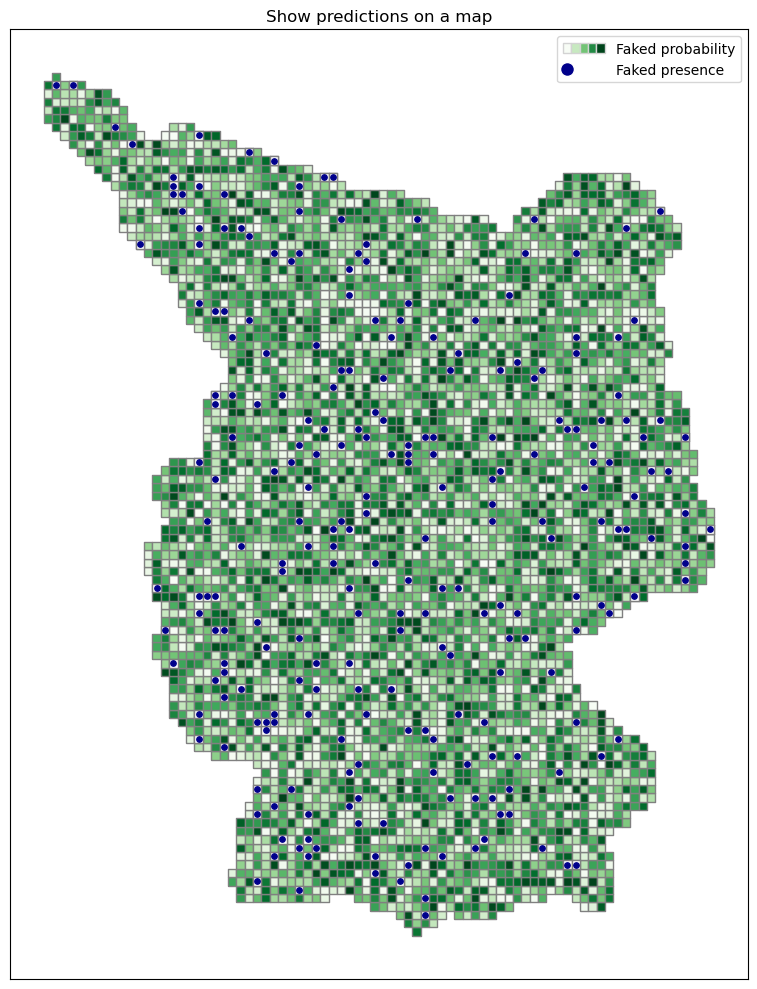

In [64]:
col = "prob"
cmap = plt.cm.Greens

fig, ax = plt.subplots(figsize=(10, 10))

# plot Germany
df.plot(column=col, ax=ax, cmap=cmap, edgecolor="grey")
# overlay areas where target = 1
_ = df.loc[df.presence == 1].plot(color="white", ax=ax, edgecolor="grey")
_ = gpd.GeoDataFrame(
    df.loc[df.presence == 1, ["centroid", "presence"]],
    geometry="centroid",
    crs=CRS("EPSG:3035"),
).plot(ax=ax, marker="o", color="darkblue", markersize=15)
# update layout
_ = ax.set_title("Show predictions on a map")
_ = ax.set_xticks([])
_ = ax.set_yticks([])
# add custom made legend
legend_cmap = [
    Patch(facecolor=cmap(0.0), edgecolor="lightgrey"),
    Patch(facecolor=cmap(0.25), edgecolor="lightgrey"),
    Patch(facecolor=cmap(0.5), edgecolor="lightgrey"),
    Patch(facecolor=cmap(0.75), edgecolor="lightgrey"),
    Patch(facecolor=cmap(1.0), edgecolor="lightgrey"),
]
legend_wolf = [
    Line2D([0], [0], marker="o", color="white", markerfacecolor="darkblue", markersize=10)
]
_ = ax.legend(
    handles=[tuple(legend_cmap)] + [tuple(legend_wolf)],
    labels=["Faked probability", "Faked presence"],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=5, pad=0)},
)
plt.tight_layout()

Unfortunately we've now lost our interactivity and also miss out on the areas being plotted on a map of the world directly. So, it's a bit like choosing between two wrongs. Because we found the plotting of the markers where wolves were present before absolutely necessary, we decided to go with the second option and miss out on the perks of the other approach. 

Do you know a way to get it all in one plot? Please get in touch, we're desperate to find out!